# Problem statement
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.
### Outline 
1. [Baseline](#baseline)
2. [Holdout](#holdout)
3. [Cross-validation](#cross_validation)
4. [Transfer model](#transfer_model)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


import warnings
warnings.filterwarnings("ignore")

In [2]:
# import data and set-up model (2.4.4)
data_path = '../../datasets/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013/property_crime_new_york_prep.csv'
data = pd.read_csv(data_path, index_col = 0)
print ("Number of rows: {}".format(len(data.index)))

Number of rows: 348


In [3]:
data['log_population'] = data['population'].apply(np.log)
data['log_property_crime'] = data['property_crime'].apply(np.log)
X = data[['log_population', 'population_squared', 'murder', 'robbery']]
Y = data['log_property_crime']
trans_data = data.drop(['population', 'property_crime'], axis = 1)

In [4]:
comparison_columns = ['Intercept', 'log_population', 'population_squared', 'murder', 'robbery']
params_df = pd.DataFrame(columns = comparison_columns)
pvalues_df = pd.DataFrame(columns = comparison_columns)
rsquared_series = pd.Series()

<a id = 'baseline'></a>
### 1. Baseline
Train and test on the whole dataset.

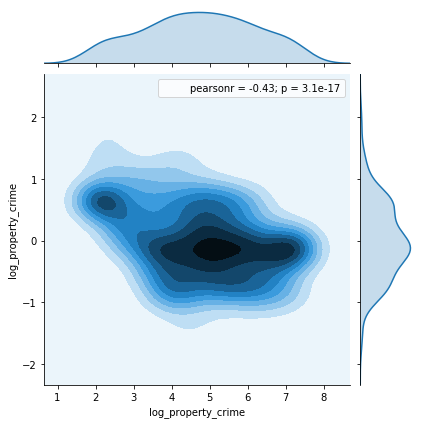

In [5]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'log_property_crime ~ log_population + population_squared + murder + robbery'

# Fit the model to our data using the formula.
lg_model = smf.ols(formula=linear_formula, data=data).fit()
params_df = params_df.append(lg_model.params, ignore_index = True)
pvalues_df = pvalues_df.append(lg_model.pvalues, ignore_index = True)
rsquared_series = rsquared_series.append(pd.Series(lg_model.rsquared))
# residual
baseline_ypred = lg_model.predict()
baseline_residual = baseline_ypred - Y

sns.jointplot(Y, baseline_residual, kind = 'kde')
plt.show()

<a id = 'holdout'></a>
### 2. Holdout
Train on 30% and test on 70% of the data.

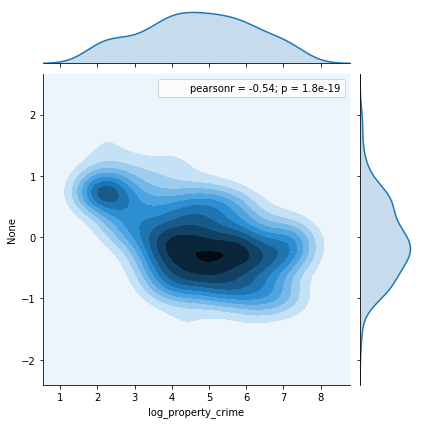

In [6]:
# Use train_test_split to create the necessary training and test groups
X_train, X_test, Y_train, Y_test = train_test_split(data[['log_population','population_squared','murder','robbery']], data['log_property_crime'], test_size=0.7, random_state=20)
holdout_df = pd.concat([X_train, Y_train], axis = 1)
# fit and get model values
lg_holdout_model = smf.ols(formula=linear_formula, data=holdout_df).fit()
params_df = params_df.append(lg_holdout_model.params, ignore_index = True)
pvalues_df = pvalues_df.append(lg_holdout_model.pvalues, ignore_index = True)
rsquared_series = rsquared_series.append(pd.Series(lg_holdout_model.rsquared))

# residual
holdout_ypred = lg_holdout_model.predict(X_test)
holdout_residual = holdout_ypred - Y
sns.jointplot(Y, holdout_residual, kind = 'kde')
plt.show()

<a id = 'cross_validation'></a>
### 3. Cross-validation
Train on data, test on fold. Perform 5 folds and find mean and standard deviation of the scores.

In [7]:
# adapted from 2.3.3_in_sample_evaluation_and_cross_validation.ipynb
total_points = data.shape[0]
folds = 5
fold_size = int(total_points / folds)
from sklearn.metrics import confusion_matrix

for fold in range(folds):
    test_vals = list(range(fold * fold_size,(fold + 1) * fold_size))
    train_vals = list(range(total_points))
    train_vals = list(set(train_vals) - set(test_vals))
    fold_X_train = X.iloc[train_vals]
    fold_X_test = X.iloc[test_vals]
    fold_Y_train = Y.iloc[train_vals]
    fold_Y_test = Y.iloc[test_vals]
    cross_val_df = pd.concat([fold_X_train, fold_Y_train], axis = 1)
    # fit and get model values
    lg_cross_val_model = smf.ols(formula=linear_formula, data=cross_val_df).fit()
    params_df = params_df.append(lg_cross_val_model.params, ignore_index = True)
    pvalues_df = pvalues_df.append(lg_cross_val_model.pvalues, ignore_index = True)
    rsquared_series = rsquared_series.append(pd.Series(lg_cross_val_model.rsquared))
    # residual
    cross_val_ypred = lg_cross_val_model.predict(fold_X_test)
    cross_val_residual = cross_val_ypred - Y

<a id = 'transfer_model'></a>
### 4. Transfer model
Train on New York 2013 data, test on New York 2014 data. Evaluate what transferred well, what transferred poorly.

In [8]:
# read data into a dataframe
data_2014_path = '../../datasets/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.csv'
data_2014 = pd.read_csv(data_2014_path, usecols = ['Population', 'Murder and nonnegligent manslaughter', 'Robbery', 'Property crime'])
display(data_2014.head(3))

,Population,Murder and nonnegligent manslaughter,Robbery,Property crime
0,"1,851",0.0,0,11
1,"2,568",0.0,1,49
2,820,0.0,0,1


In [9]:
# format data, use same transformations as 2013 data (log_population, binary murder and robbery, population_squared and log_property_crime)
data_2014.dropna(axis = 0, inplace = True)
X_2014 = pd.DataFrame(columns = ['population', 'murder', 'robbery'])
X_2014['population'] = data_2014['Population'].str.replace(',','').astype(int)
X_2014['log_population'] = X_2014['population'].apply(np.log)
X_2014['population_squared'] = X_2014['population']**2
X_2014.drop(['population'], axis = 1, inplace = True)
X_2014['murder'] = (data_2014['Murder and nonnegligent manslaughter'] > 0).astype(int)
X_2014['robbery'] = data_2014['Robbery'].str.replace(',','').astype(int)
X_2014['robbery'] = (X_2014['robbery'] > 0).astype(int)

Y_2014 = data_2014['Property crime'].str.replace(',','').astype(float)
Y_2014 = (Y_2014 + 10.0).apply(np.log)
Y_2014 = Y_2014.rename('log_property_crime');

In [10]:
# implement model on 2014 data
lg_transfer_model = smf.ols(formula=linear_formula, data=pd.concat([X_2014, Y_2014], axis = 1)).fit()
params_df = params_df.append(lg_transfer_model.params, ignore_index = True)
pvalues_df = pvalues_df.append(lg_transfer_model.pvalues, ignore_index = True)
rsquared_series = rsquared_series.append(pd.Series(lg_transfer_model.rsquared))

### Results


In [11]:
comparison_index = ['Baseline', 'Holdout', 'CV 1', 'CV 2', 'CV 3', 'CV 4', 'CV 5', 'Transfer']
params_df.index = comparison_index
pvalues_df.index = comparison_index
rsquared_series.index = comparison_index
display(params_df)
display(pvalues_df)
display(rsquared_series)

,Intercept,log_population,population_squared,murder,robbery
Baseline,-3.246125,0.824303,9.592131e-11,0.185971,0.902109
Holdout,-2.759966,0.768006,1.237587e-10,0.319171,0.823105
CV 1,-2.864930,0.785744,9.340868e-11,0.183842,0.902962
CV 2,-3.421543,0.846275,7.797813e-11,0.243720,0.854602
CV 3,-3.289570,0.832005,1.101063e-10,0.087857,0.901157
CV 4,-2.962924,0.786516,1.421257e-10,0.170371,0.929120
CV 5,-3.630723,0.864027,5.095884e-11,0.266172,0.921855
Transfer,-2.305300,0.737019,1.517376e-14,0.583963,0.691969


,Intercept,log_population,population_squared,murder,robbery
Baseline,9.098893e-13,7.309871e-41,0.140797,0.121239,1.762389e-21
Holdout,2.267057e-03,2.494328e-10,0.257822,0.094777,1.164719e-05
CV 1,3.012746e-08,1.405607e-29,0.221249,0.163311,9.163709e-17
CV 2,1.897287e-11,2.083010e-34,0.263746,0.064918,3.278443e-16
CV 3,4.280967e-11,2.389165e-34,0.118906,0.505801,3.642606e-17
CV 4,4.696304e-09,9.575068e-31,0.052826,0.211001,5.063301e-19
CV 5,9.154633e-13,6.158501e-36,0.489548,0.055955,1.648765e-18
Transfer,9.482887e-12,1.350730e-52,0.120849,0.000001,1.770689e-13


Baseline    0.813536
Holdout     0.822131
CV 1        0.798319
CV 2        0.822811
CV 3        0.820690
CV 4        0.807903
CV 5        0.820706
Transfer    0.804630
dtype: float64